# Generalized T-Maze environment

In [1]:
%load_ext autoreload
%autoreload 2

import pymdp
from pymdp.jax.envs.generalized_tmaze import GeneralizedTMaze, GeneralizedTMazeEnv
from pymdp.jax.envs.rollout import rollout
from pymdp.jax.agent import Agent

import numpy as np 
import jax.random as jr 
import jax.numpy as jnp
import jax.tree_util as jtu 

import matplotlib.pyplot as plt

### Create the environment

In this example we create a simple square environment, where multiple cues are present, and multiple reward pairs. Each cue indicates the location of one of the reward pairs. 

The agent is can move in the grid world using actions up, down, left and right, and observes the current tile it is at. 

The grid world is specified by a matrix using the following labels: 

```
0: Empty space
1: The initial position of the agent
2: Walls
3 + i: Cue for reward i
4 + i: Potential reward location i 1
4 + i: Potential reward location i 2
```

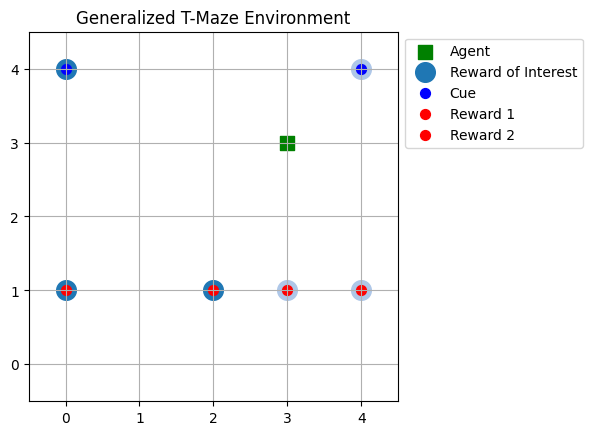

In [2]:
M = np.zeros((5, 5))

M[1,0] = 4
M[1,2] = 5
M[1,3] = 7

M[1,4] = 8
M[4,0] = 3
M[4,4] = 6

M[3,3] = 1

env = GeneralizedTMaze(M)
tmaze_env = GeneralizedTMazeEnv(M)
_ = env.render_env(tmaze_env)

#### Create the agent. 

The PyMDPEnv class consists of a params dict that contains the A, B, and D vectors of the environment. We initialize our agent using the same parameters. This means that the agent has full knowledge about the environment transitions, and likelihoods. We initialize the agent with a flat prior, i.e. it does not know where it, or the reward is. Finally, we set the C vector to have a preference only over the rewarding observation of cue-reward pair 1 (i.e. C[1][1] = 1 and zero for other values). 

In [3]:

A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]

agent = Agent(
    A, B, C, D, 
    None, None, None, 
    policy_len=5,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies
)

### Rollout an agent episode 

Using the rollout function, we can run an active inference agent in this environment over a specified number of discrete timesteps using the parameters previously set. 

In [4]:
key = jr.PRNGKey(0)
_, info, _ = rollout(agent, tmaze_env, num_timesteps=10, batch_size=1, rng_key=key)

Time t=0
[Array([[19]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


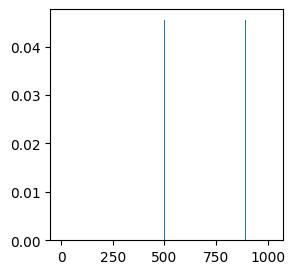

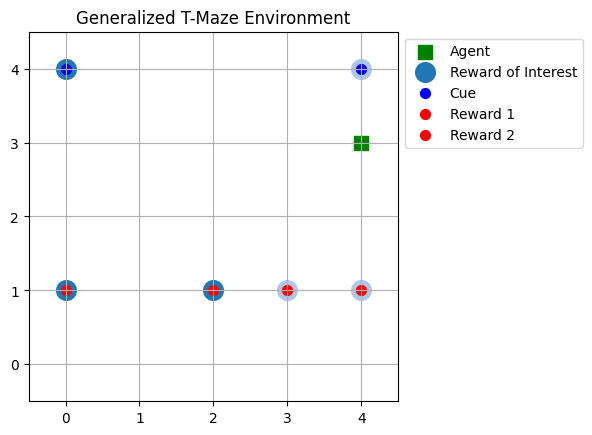

Time t=1
[Array([[24]], dtype=int32), Array([[0]], dtype=int32), Array([[1]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


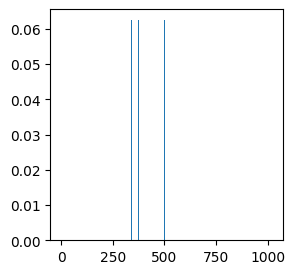

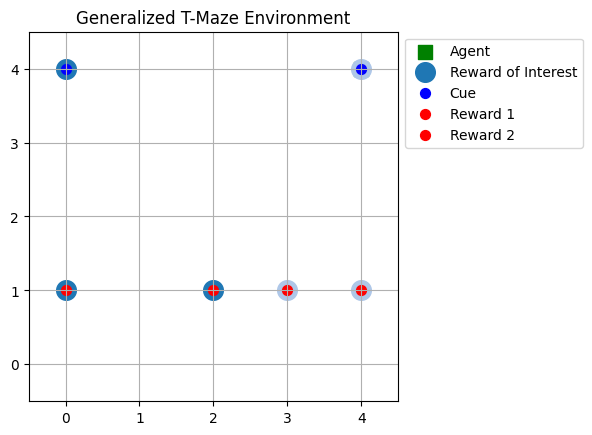

Time t=2
[Array([[23]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


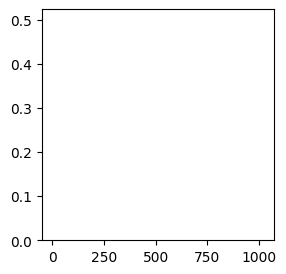

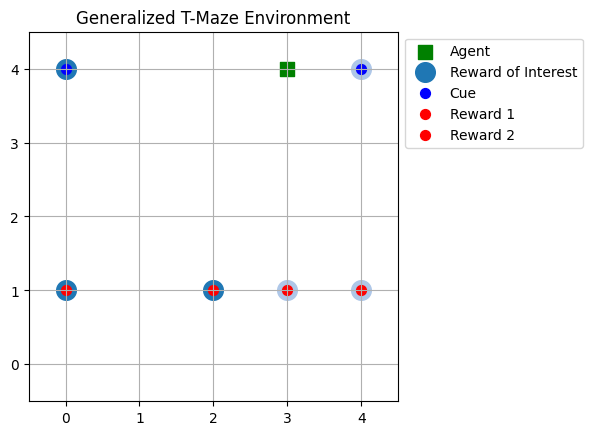

Time t=3
[Array([[22]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


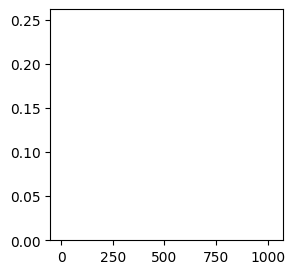

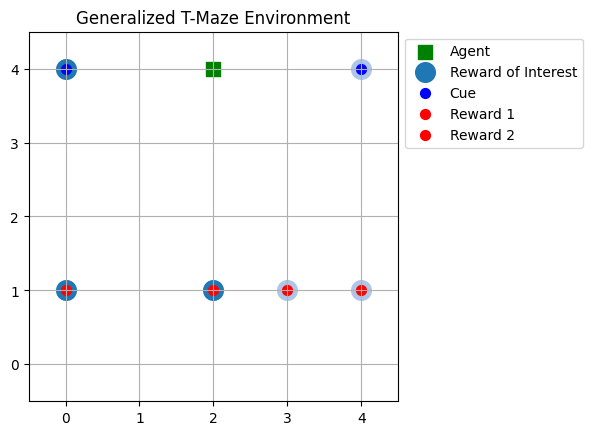

Time t=4
[Array([[21]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


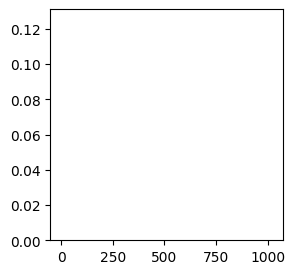

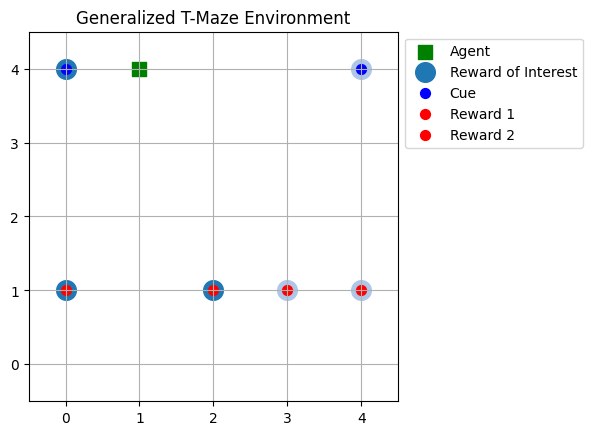

Time t=5
[Array([[20]], dtype=int32), Array([[1]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


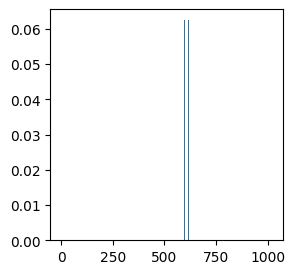

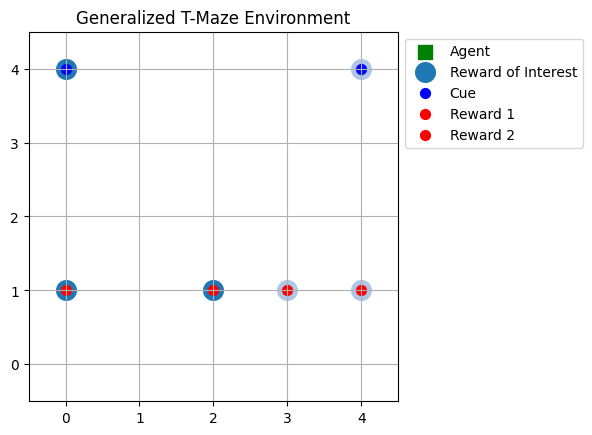

Time t=6
[Array([[15]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


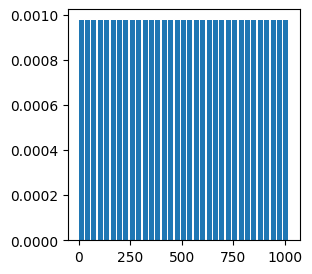

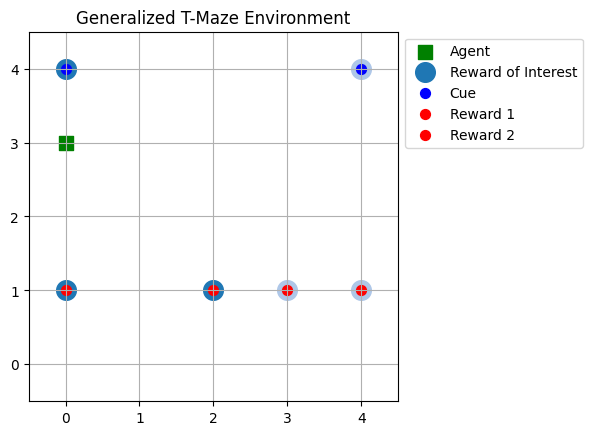

Time t=7
[Array([[10]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


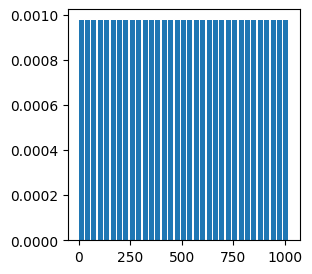

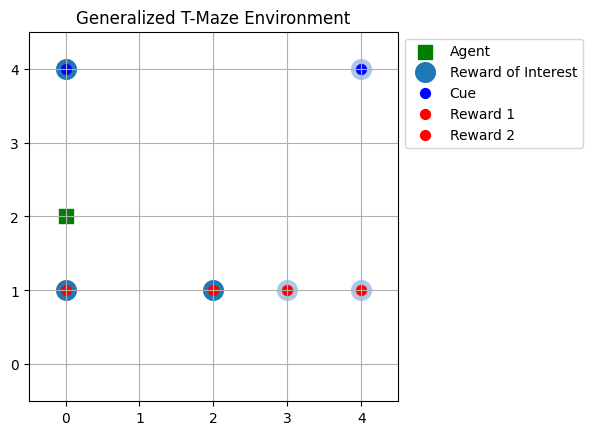

Time t=8
[Array([[5]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[1]], dtype=int32), Array([[0]], dtype=int32)]


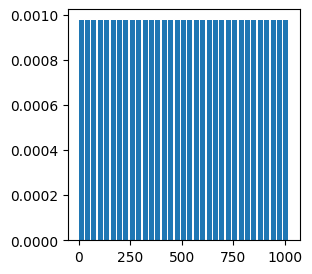

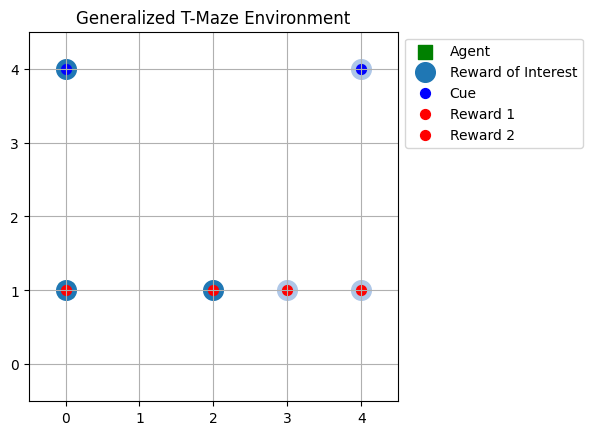

Time t=9
[Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32), Array([[0]], dtype=int32)]


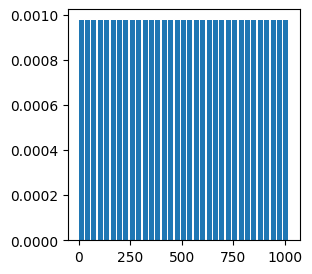

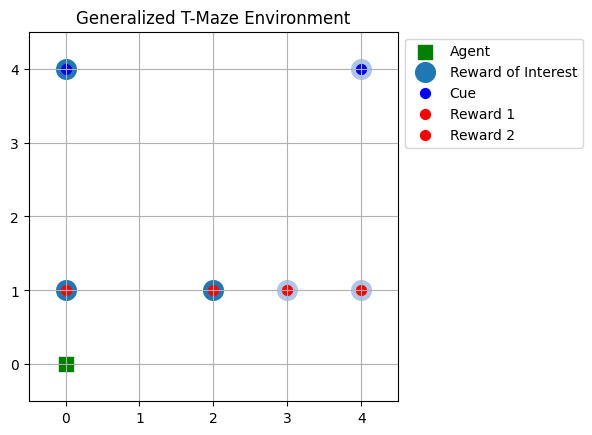

In [10]:
ims = []
for t in range(10): 
    print(f'Time t={t}')
    obs = jtu.tree_map(lambda x: x[:, t], info['observation'])
    print(obs)
    act = info['action'][:, t, 0]

    qpi = info['qpi'][:, t]

    plt.figure(figsize=(3,3))
    plt.bar(np.arange(qpi[0].shape[0]), qpi[0])
    plt.show()

    pos_idx = (obs[0][0][0])

    p = env.index_to_position(pos_idx)

    #env_state = jtu.tree_map(lambda x: print(x.shape), info['env'])
    env_state = jtu.tree_map(lambda x: x[:, t], info['env'])
    ims.append(env.render_env(env_state))
ims = [np.array(i) for i in ims]